# Blackbox Optimization with NN driven model

In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# https://docs.scipy.org/doc/scipy/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs
import scipy.optimize as optimize
from sklearn.metrics import mean_squared_error

# Using ipynb import functions defined in other nb
sys.path.append("myfun/")
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_model_nn import *
from ipynb.fs.defs.myfun_plot import *

2023-11-29 17:42:20.397225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


# Step 1: Synthetic data

## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post')

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[0] # sequence
scn = df.T[2]  # scene

## Evaluate the NN in each time interval

In [4]:
DOE =[[1,2,1]] #Design of experiment
N = scn['N. vehicles']
tstamps = scn['Tarr']
model = create_model(DOE[0])
v0 = 30

In [5]:
err_lr_best, lr_best, it_lr_best = lr_finder(model, scn, v0)
print(f"Best learning rate for NN is {lr_best}, with MAE={err_lr_best}")

Best learning rate for NN is 5e-05, with MAE=3.369779938229993


In [6]:
# parameters to set
LEARNING_RATE_NN = lr_best
LEARNING_RATE_v0=0.5
NUM_ITER=500
info_flag = True

----------------------------------------------------------------------------------------------------
We have 5 time intervals inside [72.44,73.44]
            Interval n.0: [72.44, 72.64]
                * y_true: [25.85001228 31.10049693]
                * v_ann: [21.514198303222656, 32.521827697753906, 28.250920573908385]

            Interval n.1: [72.64, 72.84]
                * y_true: [30.00006309 33.82077482]
                * v_ann: [22.538389205932617, 32.718299865722656, 28.250920573908385]

            Interval n.2: [72.84, 73.04]
                * y_true: [23.75011307 26.19081077]
                * v_ann: [23.447057723999023, 30.182479858398438, 28.250920573908385]

            Interval n.3: [73.04, 73.24]
                * y_true: [29.90025591 27.11111625]
                * v_ann: [23.802284240722656, 31.876317977905273, 28.250920573908385]

            Interval n.4: [73.24, 73.44]
                * y_true: [25.05033948 28.161422  ]
                * v_ann: [23.26887130737

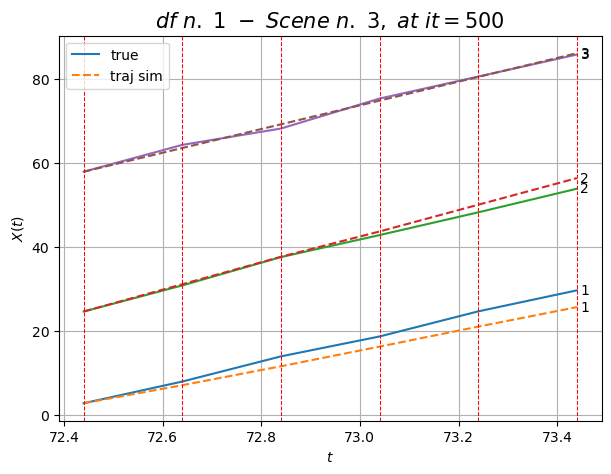

----------------------------------------------------------------------------------------------------


In [7]:
t_list, x_list, v_list, _, it = solve_nn_scn_custom(model, scn, v0,
                                                    LEARNING_RATE_NN, LEARNING_RATE_v0,
                                                    NUM_ITER, info_flag)

## Create synthetic data

In [8]:
# Take samples from the simulation
Nt = len(t_list)  # timestamps original dataset
M = 5                # Number of samples
Mt = int(Nt/M)       # timestamp to take equispaced samples

idx = list(range(0,Nt,1+Mt))    # indexes to extract
tshat, Xhat = np.array(t_list)[idx], [traj[idx] for traj in np.array(x_list)]

## Plot

In [9]:
# Params for the plot
trajs = [scn['Xarr'], np.array(x_list)]
labels_plot = ["true","nn sim"]
title = f"Trajs simulated by NN driven LWR model"

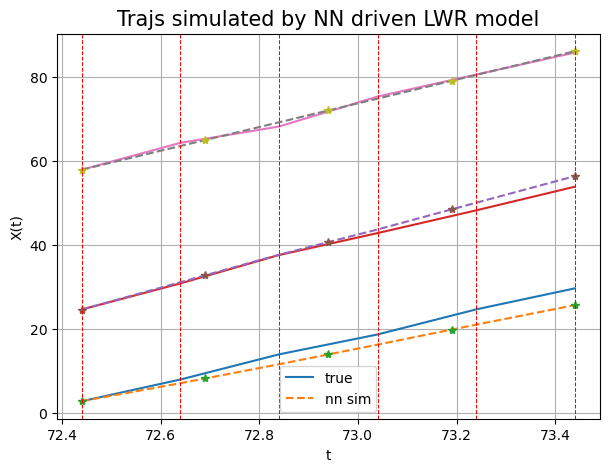

In [10]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(t_list, x_list[veh], '--')
    ax.plot(tshat, Xhat[veh], '*')

for ts in tstamps:
    ax.axvline(x = ts, color = 'red', linestyle = '--', linewidth=0.75)
    
# Annotate the name of each variable at the last value
plot_annotation(ax, scn, trajs, scale=1.004)

ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# Limits for the plot
#plot_limits(ax, scn, trajs, xbal=0.01, ybal=0.05)
plt.legend(labels_plot)
plt.grid()
plt.show()

# Step 2: Optimization with blackbox approach

In [11]:
# definition with freezed parameteres regarding the scene.
def f_wrapped(v0):
    t_list, x_list, _, _, _ = solve_nn_scn_custom(model, scn, v0,
                                                LEARNING_RATE_NN, LEARNING_RATE_v0,
                                                NUM_ITER = 250, info_flag=True)
    
    return x_list

In [12]:
def loss_fun(v0):
    "Loss function"
    
    X = f_wrapped(v0)
    Xupd = [traj[idx] for traj in np.array(X)] # extracting the same index as in X
        
    mse = mean_squared_error(Xhat, Xupd)

    return mse

----------------------------------------------------------------------------------------------------
We have 5 time intervals inside [72.44,73.44]
            Interval n.0: [72.44, 72.64]
                * y_true: [25.85001228 31.10049693]
                * v_ann: [21.53382682800293, 32.50838088989258, 28.251297822846364]

            Interval n.1: [72.64, 72.84]
                * y_true: [30.00006309 33.82077482]
                * v_ann: [22.555166244506836, 32.70458221435547, 28.251297822846364]

            Interval n.2: [72.84, 73.04]
                * y_true: [23.75011307 26.19081077]
                * v_ann: [23.462947845458984, 30.178674697875977, 28.251297822846364]

            Interval n.3: [73.04, 73.24]
                * y_true: [29.90025591 27.11111625]
                * v_ann: [23.815757751464844, 31.865751266479492, 28.251297822846364]

            Interval n.4: [73.24, 73.44]
                * y_true: [25.05033948 28.161422  ]
                * v_ann: [23.28401947021484

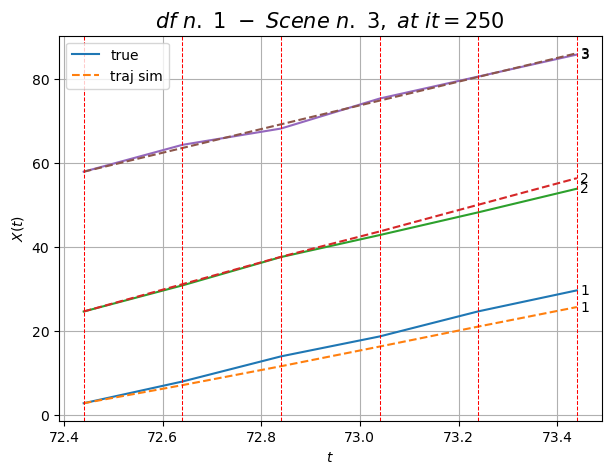

----------------------------------------------------------------------------------------------------


In [13]:
# using the parameters used in the creation of synthetic data the loss must be 0!
mse = loss_fun(v0=30)

In [14]:
mse

4.874034161874478e-05

In [15]:
# initial_guess = [30]

# #result = optimize.minimize(loss_fun, initial_guess, method="Nelder-Mead", tol = 1e0, options={'maxiter':3})
# result = optimize.minimize(loss_fun, initial_guess, method="Powell", tol = 10000)
# if result.success:
#     fitted_params = result.x
#     print(fitted_params)
# else:
#     raise ValueError(result.message)

In [16]:
# fitted_params

In [17]:
# result.message